<a href="https://colab.research.google.com/github/alyahoang99/GANs/blob/main/GAN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preprocessing

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Hyperparemeters explanation

In [4]:
# hyperparameters definition
# === Data shape ===
SEQ_LENGTH = 7           # Length of each time series sequence (7 days)
FEATURE_DIM = 3        # Number of features

# === Latent space ===
LATENT_DIM = 100         # Dimensionality of the random noise vector z

# === Training ===
BATCH_SIZE = 100        # Number of samples per training batch
EPOCHS = 300          # Number of training epochs
LEARNING_RATE = 1e-5  # Learning rate for both Generator and Discriminator
BETA_1 = 0.2             # Beta1 hyperparameter for Adam optimizer (helps GAN stability)

In [5]:
# data preprocess
# Load dataset

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GANs/resampleddata (1).csv", parse_dates=["Timestamp"])



# Select relevant features
features = ['Value', 'Value_HeatPump', 'Value_OtherAppliances']
data = df[features].values.astype(np.float32)

# Normalize data to [-1, 1] for tanh
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

def create_sequences(data, seq_len):
    sequences = []
    for i in range(len(data) - seq_len + 1):
        seq = data[i:i + seq_len]
        if len(seq) == seq_len:
            sequences.append(seq)
    return np.array(sequences)

sequence_data = create_sequences(data, SEQ_LENGTH)
print("Sequence data shape:", sequence_data.shape)  # (num_samples, 7, 5)


Sequence data shape: (1011, 7, 3)


In [6]:
data

array([[0.        , 0.02659541, 0.003696  ],
       [0.61078984, 0.50875247, 0.6995842 ],
       [0.6552573 , 0.49473614, 0.8162228 ],
       ...,
       [0.06035511, 0.08418401, 0.05910306],
       [0.00939157, 0.00175665, 0.05771706],
       [0.00621854, 0.        , 0.05309705]], dtype=float32)

In [7]:

BUFFER_SIZE = 1000  # Optional, for shuffling

dataset = tf.data.Dataset.from_tensor_slices(sequence_data)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [8]:
dataset

<_BatchDataset element_spec=TensorSpec(shape=(100, 7, 3), dtype=tf.float32, name=None)>

In [9]:
sequence_data

array([[[0.        , 0.02659541, 0.003696  ],
        [0.61078984, 0.50875247, 0.6995842 ],
        [0.6552573 , 0.49473614, 0.8162228 ],
        ...,
        [0.6072642 , 0.5189239 , 0.6781672 ],
        [0.52924365, 0.47456542, 0.56613207],
        [0.5474042 , 0.43638593, 0.6573607 ]],

       [[0.61078984, 0.50875247, 0.6995842 ],
        [0.6552573 , 0.49473614, 0.8162228 ],
        [0.6121251 , 0.5125975 , 0.6973567 ],
        ...,
        [0.52924365, 0.47456542, 0.56613207],
        [0.5474042 , 0.43638593, 0.6573607 ],
        [0.46323264, 0.42569864, 0.486569  ]],

       [[0.6552573 , 0.49473614, 0.8162228 ],
        [0.6121251 , 0.5125975 , 0.6973567 ],
        [0.6072642 , 0.5189239 , 0.6781672 ],
        ...,
        [0.5474042 , 0.43638593, 0.6573607 ],
        [0.46323264, 0.42569864, 0.486569  ],
        [0.46894106, 0.43144765, 0.4914035 ]],

       ...,

       [[0.05683702, 0.00990111, 0.15114015],
        [0.07165201, 0.02361034, 0.16531366],
        [0.06604858, 0

## Model Architecture

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

# === Generator ===
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(SEQ_LENGTH, LATENT_DIM)),
        layers.LSTM(128, return_sequences=True),
        layers.LeakyReLU(0.2),
        layers.LSTM(64, return_sequences=True),
        layers.LeakyReLU(0.2),
        layers.TimeDistributed(layers.Dense(FEATURE_DIM, activation='tanh'))
    ])
    return model

# === Discriminator ===
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(SEQ_LENGTH, FEATURE_DIM)),
        layers.LSTM(64, return_sequences=True),
        layers.LeakyReLU(0.2),
        layers.LSTM(32),
        layers.LeakyReLU(0.2),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [11]:
# loss function
# Binary Crossentropy loss
bce_loss = tf.keras.losses.BinaryCrossentropy()

def generator_loss(fake_output):
    return bce_loss(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = bce_loss(tf.ones_like(real_output), real_output)
    fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [12]:
# Optimizers
gen_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
disc_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [13]:
# Instantiate models
generator = build_generator()
discriminator = build_discriminator()

In [14]:
import time

def train(dataset, epochs):
    gen_losses = []
    disc_losses = []

    for epoch in range(epochs):
        start_time = time.time()  # Start timing

        g_loss_epoch = 0
        d_loss_epoch = 0
        batch_count = 0

        for real_sequences in dataset:
            batch_size = real_sequences.shape[0]
            noise = tf.random.normal([batch_size, SEQ_LENGTH, LATENT_DIM])

            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                fake_sequences = generator(noise, training=True)

                real_output = discriminator(sequence_data, training=True)
                fake_output = discriminator(fake_sequences, training=True)

                gen_loss = generator_loss(fake_output)
                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

            gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
            disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

            g_loss_epoch += gen_loss.numpy()
            d_loss_epoch += disc_loss.numpy()
            batch_count += 1

        avg_gen_loss = g_loss_epoch / batch_count
        avg_disc_loss = d_loss_epoch / batch_count
        gen_losses.append(avg_gen_loss)
        disc_losses.append(avg_disc_loss)

        duration = time.time() - start_time  # End timing

        print(f"Epoch {epoch+1}/{epochs} — Gen Loss: {avg_gen_loss:.4f} — Disc Loss: {avg_disc_loss:.4f} — Time: {duration:.2f} sec")

    return gen_losses, disc_losses


In [15]:
# Train
gen_losses, disc_losses = train(dataset, EPOCHS)

Epoch 1/300 — Gen Loss: 0.6935 — Disc Loss: 1.3948 — Time: 10.27 sec
Epoch 2/300 — Gen Loss: 0.6935 — Disc Loss: 1.3942 — Time: 8.12 sec
Epoch 3/300 — Gen Loss: 0.6934 — Disc Loss: 1.3936 — Time: 10.22 sec
Epoch 4/300 — Gen Loss: 0.6932 — Disc Loss: 1.3931 — Time: 10.22 sec
Epoch 5/300 — Gen Loss: 0.6932 — Disc Loss: 1.3924 — Time: 8.26 sec
Epoch 6/300 — Gen Loss: 0.6931 — Disc Loss: 1.3918 — Time: 10.22 sec
Epoch 7/300 — Gen Loss: 0.6931 — Disc Loss: 1.3912 — Time: 6.68 sec
Epoch 8/300 — Gen Loss: 0.6929 — Disc Loss: 1.3907 — Time: 8.50 sec
Epoch 9/300 — Gen Loss: 0.6930 — Disc Loss: 1.3899 — Time: 6.75 sec
Epoch 10/300 — Gen Loss: 0.6929 — Disc Loss: 1.3894 — Time: 8.61 sec
Epoch 11/300 — Gen Loss: 0.6929 — Disc Loss: 1.3887 — Time: 6.67 sec
Epoch 12/300 — Gen Loss: 0.6929 — Disc Loss: 1.3880 — Time: 8.35 sec
Epoch 13/300 — Gen Loss: 0.6928 — Disc Loss: 1.3874 — Time: 6.70 sec
Epoch 14/300 — Gen Loss: 0.6928 — Disc Loss: 1.3867 — Time: 8.40 sec
Epoch 15/300 — Gen Loss: 0.6927 — Disc 

In [16]:
import matplotlib.pyplot as plt

def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label="Generator Loss")
    plt.plot(disc_losses, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GAN Training Losses")
    plt.legend()
    plt.grid(True)
    plt.show()

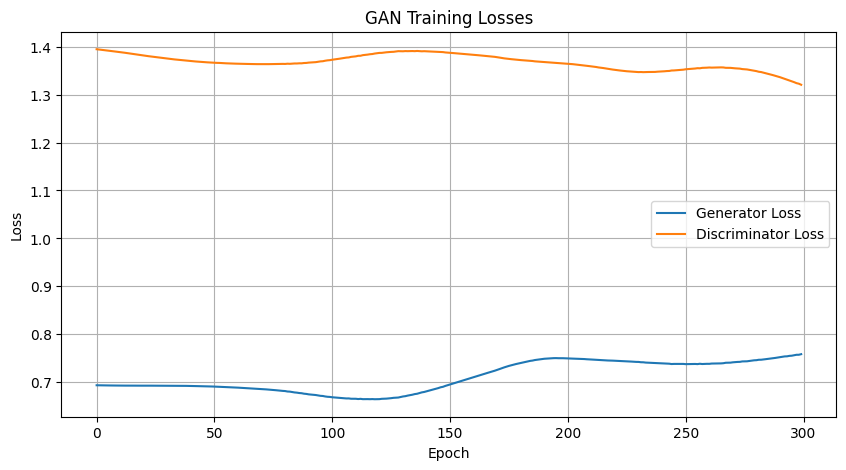

In [17]:
plot_losses(gen_losses, disc_losses)

In [18]:
def generate_synthetic_data(generator, num_samples, seq_length, latent_dim, feature_dim):
    """
    Generate synthetic time-series data using the trained generator model.

    Args:
        generator (tf.keras.Model): Trained generator model.
        num_samples (int): Number of synthetic sequences to generate.
        seq_length (int): Length of each time-series sequence.
        latent_dim (int): Dimensionality of the noise vector.
        feature_dim (int): Number of features per time step.

    Returns:
        np.ndarray: Generated synthetic data of shape (num_samples, seq_length, feature_dim).
    """
    # Sample random noise vectors
    noise = tf.random.normal([num_samples, seq_length, latent_dim])

    # Generate synthetic sequences
    synthetic_data = generator(noise, training=False)

    # Convert to numpy
    return synthetic_data.numpy()


In [19]:
SYNTHETIC_SAMPLES = 10000
synthetic = generate_synthetic_data(generator, SYNTHETIC_SAMPLES, SEQ_LENGTH, LATENT_DIM, FEATURE_DIM)

print(synthetic.shape)

(10000, 7, 3)


In [87]:
synthetic

array([[[ 0.55209327,  0.52151126,  0.47641006],
        [ 0.6485231 ,  0.61797047,  0.5933934 ],
        [ 0.55270547,  0.60163087,  0.4867874 ],
        ...,
        [ 0.62773496,  0.5439885 ,  0.514355  ],
        [ 0.64318246,  0.5130059 ,  0.5095682 ],
        [ 0.71024567,  0.56792814,  0.5854463 ]],

       [[ 0.24638863,  0.22884648,  0.18521635],
        [ 0.23142564,  0.21216993,  0.16343288],
        [ 0.16886817,  0.1366589 ,  0.09374377],
        ...,
        [ 0.26614174,  0.14524749,  0.22986445],
        [ 0.38250312,  0.25933525,  0.34052238],
        [ 0.5776378 ,  0.45405632,  0.500776  ]],

       [[ 0.19881223,  0.16145237,  0.17854531],
        [-0.07211675,  0.07251588,  0.06839403],
        [-0.03836138,  0.11677714,  0.0643362 ],
        ...,
        [ 0.266523  ,  0.2593215 ,  0.3620322 ],
        [ 0.30150062,  0.21950376,  0.40273416],
        [ 0.3491741 ,  0.20566891,  0.40592182]],

       ...,

       [[ 0.5236225 ,  0.49816605,  0.47425416],
        [ 0

In [88]:
import pandas as pd

# flatten sequence into tabular form if needed
generated_data_flat = synthetic.reshape(-1, len(features))
df_fake = pd.DataFrame(generated_data_flat, columns=features)
# Save to CSV
df_fake.to_csv('generated_data_flat.csv', index=False)

In [89]:
df_fake.head()

,Value,Value_HeatPump,Value_OtherAppliances
0,0.552093,0.521511,0.476410
1,0.648523,0.617970,0.593393
2,0.552705,0.601631,0.486787
3,0.532334,0.542644,0.484597
4,0.627735,0.543989,0.514355


In [91]:
# statistical overlap
def evaluate_statistics(sequence_data,synthetic):
    real_flat = sequence_data.reshape(-1, sequence_data.shape[-1])
    fake_flat = synthetic.reshape(-1, synthetic.shape[-1])

    stats = {}
    for i, feature_name in enumerate(features):
        real_mean = np.mean(real_flat[:, i])
        fake_mean = np.mean(fake_flat[:, i])
        real_std = np.std(real_flat[:, i])
        fake_std = np.std(fake_flat[:, i])

        stats[feature_name] = {
            "real_mean": real_mean,
            "fake_mean": fake_mean,
            "real_std": real_std,
            "fake_std": fake_std
        }
    return stats

In [92]:
# Evaluate
stats = evaluate_statistics(sequence_data, synthetic)
for feat, s in stats.items():
    print(f"{feat}: Real μ={s['real_mean']:.3f}, Fake μ={s['fake_mean']:.3f} | Real σ={s['real_std']:.3f}, Fake σ={s['fake_std']:.3f}")

Value: Real μ=0.359, Fake μ=0.401 | Real σ=0.244, Fake σ=0.252
Value_HeatPump: Real μ=0.349, Fake μ=0.352 | Real σ=0.229, Fake σ=0.220
Value_OtherAppliances: Real μ=0.360, Fake μ=0.381 | Real σ=0.251, Fake σ=0.216


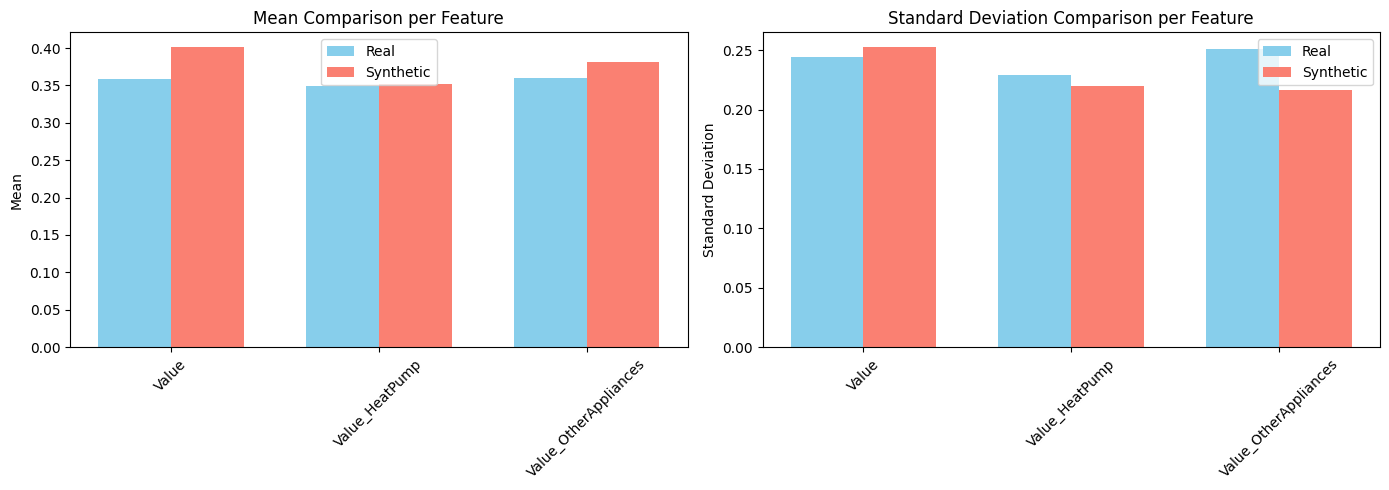

In [93]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'stats' is the output dictionary from evaluate_statistics()
features = list(stats.keys())
real_means = [stats[f]['real_mean'] for f in features]
fake_means = [stats[f]['fake_mean'] for f in features]
real_stds = [stats[f]['real_std'] for f in features]
fake_stds = [stats[f]['fake_std'] for f in features]

x = np.arange(len(features))  # label locations
width = 0.35  # width of the bars

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot means
axs[0].bar(x - width/2, real_means, width, label='Real', color='skyblue')
axs[0].bar(x + width/2, fake_means, width, label='Synthetic', color='salmon')
axs[0].set_ylabel('Mean')
axs[0].set_title('Mean Comparison per Feature')
axs[0].set_xticks(x)
axs[0].set_xticklabels(features, rotation=45)
axs[0].legend()

# Plot stds
axs[1].bar(x - width/2, real_stds, width, label='Real', color='skyblue')
axs[1].bar(x + width/2, fake_stds, width, label='Synthetic', color='salmon')
axs[1].set_ylabel('Standard Deviation')
axs[1].set_title('Standard Deviation Comparison per Feature')
axs[1].set_xticks(x)
axs[1].set_xticklabels(features, rotation=45)
axs[1].legend()

plt.tight_layout()
plt.show()


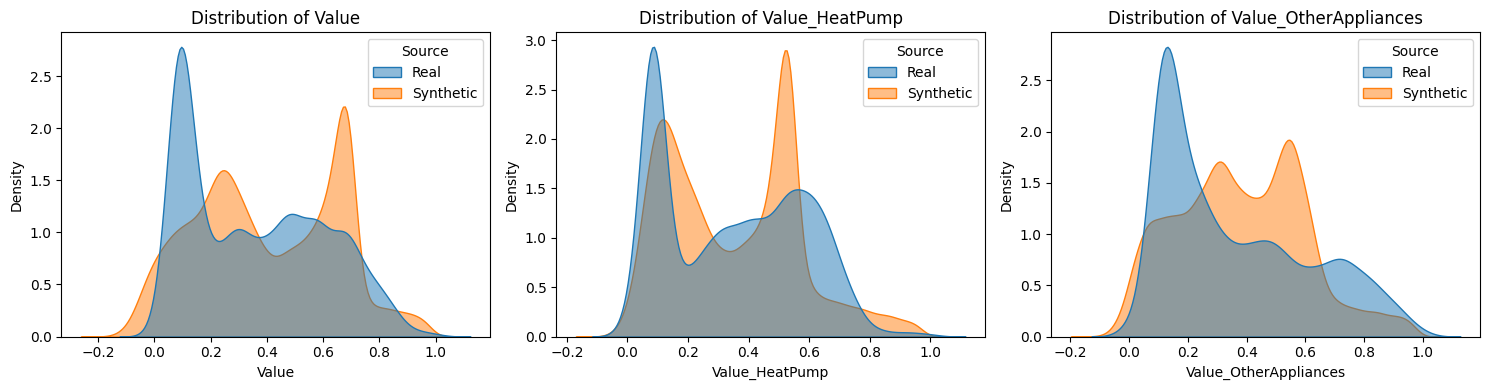

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example variable shapes:
# sequence_data: shape (n_samples, seq_len, n_features)
# synthetic: shape (n_samples, seq_len, n_features)

# Assume feature names are in correct order from `stats.keys()`
feature_names = list(stats.keys())

# Reshape from (samples, time, features) to (samples * time, features)
real_reshaped = sequence_data.reshape(-1, sequence_data.shape[2])
synthetic_reshaped = synthetic.reshape(-1, synthetic.shape[2])

# Create DataFrames
real_df = pd.DataFrame(real_reshaped, columns=feature_names)
real_df["Source"] = "Real"

synthetic_df = pd.DataFrame(synthetic_reshaped, columns=feature_names)
synthetic_df["Source"] = "Synthetic"

# Combine for plotting
combined_df = pd.concat([real_df, synthetic_df], axis=0)

# Plot distributions
num_features = len(feature_names)
cols = 3
rows = (num_features + cols - 1) // cols

plt.figure(figsize=(5 * cols, 4 * rows))

for i, feature in enumerate(feature_names):
    plt.subplot(rows, cols, i + 1)
    sns.kdeplot(data=combined_df, x=feature, hue="Source", fill=True, common_norm=False, alpha=0.5)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")

plt.tight_layout()
plt.show()


In [54]:
!pip install tslearn
!pip install tabulate

In [95]:
import numpy as np
from scipy.stats import wasserstein_distance
from scipy.special import rel_entr
from statsmodels.tsa.stattools import acf

In [96]:
# If data was scaled with MinMaxScaler before training
real_sequences = scaler.inverse_transform(sequence_data.reshape(-1, FEATURE_DIM)).reshape(-1, SEQ_LENGTH, FEATURE_DIM)
generated_sequences = scaler.inverse_transform(synthetic.reshape(-1, FEATURE_DIM)).reshape(-1, SEQ_LENGTH, FEATURE_DIM)

In [97]:
import numpy as np
from scipy.stats import entropy, wasserstein_distance


# === Metric Functions ===
def kl_divergence(p, q):
    p += 1e-8
    q += 1e-8
    return entropy(p, q)

def js_divergence(p, q):
    p += 1e-8
    q += 1e-8
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))

# === Evaluation Function ===
def evaluate_gan_outputs(real_sequences, generated_sequences, feature_names=None):
    if isinstance(real_sequences, tf.Tensor):
        real_sequences = real_sequences.numpy()
    if isinstance(generated_sequences, tf.Tensor):
        generated_sequences = generated_sequences.numpy()

    real_flat = real_sequences.reshape(-1, real_sequences.shape[-1])
    gen_flat = generated_sequences.reshape(-1, generated_sequences.shape[-1])
    n_features = real_flat.shape[-1]

    print("\n📊 GAN Evaluation Metrics")
    for i in range(n_features):
        real_vals = real_flat[:, i]
        gen_vals = gen_flat[:, i]

        # Histogram for divergence metrics
        # Use density=True for normalized histograms suitable for divergence measures
        bins = np.histogram_bin_edges(np.concatenate([real_vals, gen_vals]), bins="auto")
        real_hist, _ = np.histogram(real_vals, bins=bins, density=True)
        gen_hist, _ = np.histogram(gen_vals, bins=bins, density=True)

        # Although density=True normalizes, explicitly re-normalizing
        # helps handle potential floating point issues and ensures sum is exactly 1.
        real_hist /= (np.sum(real_hist) + 1e-8) # Add small epsilon to avoid division by zero
        gen_hist /= (np.sum(gen_hist) + 1e-8)   # Add small epsilon

        # Metrics
        kl = kl_divergence(real_hist, gen_hist)
        js = js_divergence(real_hist, gen_hist)
        wd = wasserstein_distance(real_vals, gen_vals)

        fname = feature_names[i] if feature_names else f"Feature {i+1}"
        print(f"\n🔹 {fname}")
        print(f"  - KL Divergence        : {kl:.4f}")
        print(f"  - JS Divergence        : {js:.4f}")
        print(f"  - Wasserstein Distance : {wd:.4f}")
        # Removed MSE and MAE output

In [98]:
evaluate_gan_outputs(
    real_sequences=real_sequences,
    generated_sequences=synthetic,
    feature_names=["Value", "Value_HeatPump", "Value_OtherAppliances", "dow_sin", "dow_cos"] # Added the missing feature names
)


📊 GAN Evaluation Metrics

🔹 Value
  - KL Divergence        : 11.6787
  - JS Divergence        : 0.6930
  - Wasserstein Distance : 49.9554

🔹 Value_HeatPump
  - KL Divergence        : 11.7472
  - JS Divergence        : 0.6863
  - Wasserstein Distance : 28.1701

🔹 Value_OtherAppliances
  - KL Divergence        : 11.6993
  - JS Divergence        : 0.6828
  - Wasserstein Distance : 21.4534


In [68]:


kl = compute_kl_divergence(sequence_data, synthetic)
wd = compute_wasserstein_distance(sequence_data, synthetic)
acf_diff = autocorrelation_score(sequence_data, synthetic)

print("KL Divergence (per feature):", kl)
print("Wasserstein Distance (per feature):", wd)
print("Autocorrelation MSE (per feature):", acf_diff)


NameError: name 'compute_kl_divergence' is not defined